# Chamber Rates Fitting

In this notebook we now will use the chamber observations and process simulations to fit the chamber rates. We will use the same approach as in the previous notebook, but now we will fit the rates for each chamber. We will be fitting the free parameters of `wall_eddy_diffusivity` and `alpha_collision_efficiency`.


In [1]:
import numpy as np

import matplotlib.pyplot as plt

from particula.data.process import chamber_rate_fitting, lognormal_2mode
from particula.data import (
    stream_stats,
    loader,
    loader_interface,
    settings_generator,
)

# all the imports
from particula.data.tests.example_data.get_example_data import get_data_folder
from particula.util.convert import distribution_convert_pdf_pms
from particula.util import convert, time_manage
from particula.util.input_handling import convert_units

# set the parent directory of the data folders
path = get_data_folder()
print("Path to data folder:")
print(path.rsplit("particula")[-1])

Path to data folder:
\data\tests\example_data


## Load and Prepare Data

First we will load the data, clean and prepare it for the fitting of the size distributions.

  Loading file: 2023-09-25_160155_SMPS.csv
Stream saved: stream_sizer_2d_cleaned.pk


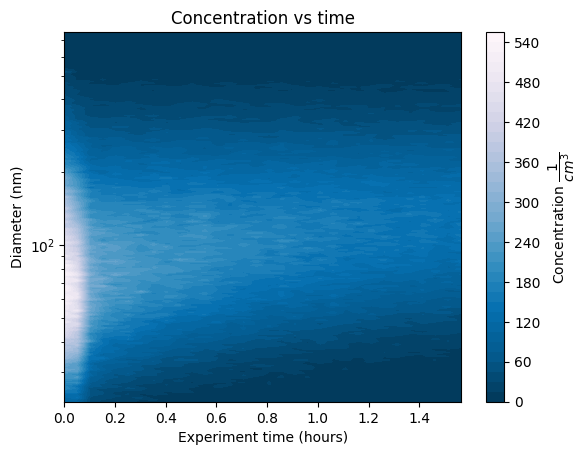

In [2]:
# load the 2d data
smps_2d_stream_settings = settings_generator.load_settings_for_stream(
    path=path,
    subfolder="chamber_data",
    settings_suffix="_smps_2d",
)
stream_sizer_2d = loader_interface.load_files_interface(
    path=path, settings=smps_2d_stream_settings
)
# 1 convert to dn/dDp
stream_sizer_2d.data = convert.convert_sizer_dn(
    diameter=np.array(stream_sizer_2d.header, dtype=float),
    dn_dlogdp=stream_sizer_2d.data,
)
# Dilution correction
dilution_correction = 2
# scale the concentrations
stream_sizer_2d.data *= dilution_correction

# select the time window
bad_window_start_epoch = time_manage.time_str_to_epoch(
    time="09-25-2023 19:00:00",
    time_format="%m-%d-%Y %H:%M:%S",
    timezone_identifier="UTC",
)
bad_window_end_epoch = time_manage.time_str_to_epoch(
    time="09-25-2023 19:45:00",
    time_format="%m-%d-%Y %H:%M:%S",
    timezone_identifier="UTC",
)
# remove the bad data
stream_sizer_2d = stream_stats.remove_time_window(
    stream=stream_sizer_2d,
    epoch_start=bad_window_start_epoch,
    epoch_end=bad_window_end_epoch,
)
# remove the first few bins
stream_sizer_2d.data = stream_sizer_2d.data[:, 20:]
stream_sizer_2d.header = stream_sizer_2d.header[20:]

# crop start
experiment_start_epoch = time_manage.time_str_to_epoch(
    time="09-25-2023 15:25:00",
    time_format="%m-%d-%Y %H:%M:%S",
    timezone_identifier="UTC",
)
# crop the end
experiment_end_epoch = time_manage.time_str_to_epoch(
    time="09-25-2023 17:00:00",
    time_format="%m-%d-%Y %H:%M:%S",
    timezone_identifier="UTC",
)  # time="09-26-2023 07:00:00",
# select the time window
stream_sizer_2d = stream_stats.select_time_window(
    stream=stream_sizer_2d,
    epoch_start=experiment_start_epoch,
    epoch_end=experiment_end_epoch,
)

# # save the cleaned data
# loader.save_stream(
#     stream=stream_sizer_2d,
#     path=path,
#     suffix_name="_sizer_2d_cleaned",
#     folder="chamber_analysis",
# )

experiment_time = time_manage.relative_time(
    epoch_array=stream_sizer_2d.time,
    units="hours",
)
# Plot the 2d data
fig, ax = plt.subplots(1, 1)
plt.contourf(
    experiment_time,
    stream_sizer_2d.header_float,
    stream_sizer_2d.data.T,
    cmap=plt.cm.PuBu_r,
    levels=50,
)
plt.yscale("log")
ax.set_xlabel("Experiment time (hours)")
ax.set_ylabel("Diameter (nm)")
ax.set_title("Concentration vs time")
plt.colorbar(label=r"Concentration $\dfrac{1}{cm^3}$", ax=ax)
plt.show()

## Lognormal Distribution Fitting

We use a 2-mode lognormal distribution to fit the size distributions. This means we first convert the measured observations to a pdf and then fit the lognormal distribution to it. We will use a machine learning model to guess the initial parameters of the lognormal distribution. Then a scipy optimization routine will be used to optimize the lognormal parameters.

The fit parameters are the following:

- `Mode_1`: Mode 1 of the lognormal distribution
- `Mode_2`: Mode 2 of the lognormal distribution
- `GSD_1`: Geometric standard deviation of mode 1
- `GSD_2`: Geometric standard deviation of mode 2
- `N_1`: Number concentration of mode 1
- `N_2`: Number concentration of mode 2

This is likely the computational part of the notebook, so save the results in a file to avoid running it again. This can be done by uncommenting the `save_stream` call.

Lognormal 2-mode: 100%|██████████| 32/32 [03:08<00:00,  5.89s/it]


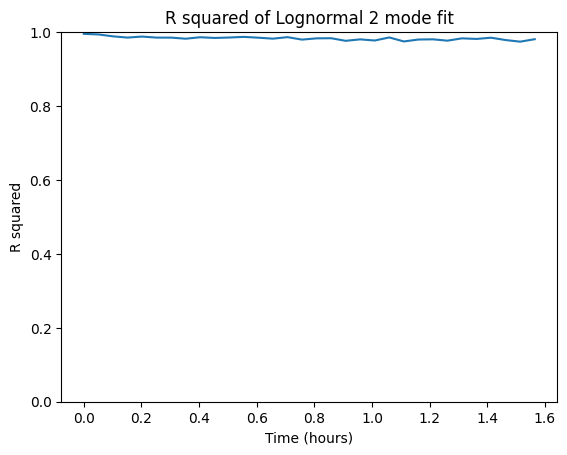

In [3]:
radius_m = stream_sizer_2d.header_float / 2 * convert_units(old="nm", new="m")
concentration_m3_pmf = stream_sizer_2d.data * convert_units(
    old="1/cm^3", new="1/m^3"
)

concentration_m3_pdf = distribution_convert_pdf_pms(
    x_array=radius_m,
    distribution=concentration_m3_pmf,
    to_pdf=True,
)

# fit the lognormal pdf distribution with 2 modes

stream_lognormal_prameters = lognormal_2mode.guess_and_optimize_looped(
    experiment_time=stream_sizer_2d.time,
    radius_m=radius_m,
    concentration_m3_pdf=concentration_m3_pdf,
)

# save the stream to pickle
# loader.save_stream(
#     stream=stream_lognormal_prameters,
#     path=path,
#     folder="chamber_analysis",
#     suffix_name="_optimized_lognormal_2mode",
# )
# # save to csv
# loader.save_stream_to_csv(
#     stream=fitted_stream,
#     path=path,
#     folder="chamber_analysis",
#     suffix_name="optimized_lognormal_2mode",
# )

# plot the 2 mode lognormal fit
fig, ax = plt.subplots(1, 1)
plt.plot(experiment_time, stream_lognormal_prameters["R2"])
ax.set_ylim(0, 1)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("R squared")
ax.set_title("R squared of Lognormal 2 mode fit")
plt.show()

**Get the new distribution**

With the new parameters we can now calculate the new distribution. This is also where we can resample. We can change: 

- `radius_min`: Minimum radius of the distribution
- `radius_max`: Maximum radius of the distribution
- `num_radius_bins`: Number of bins in the radius

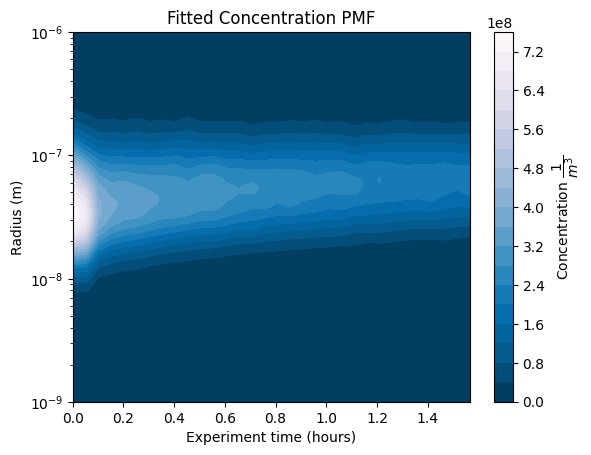

In [5]:
# Create the fitted pmf
(fitted_pmf_stream, fitted_pmf_concentration) = (
    lognormal_2mode.create_lognormal_2mode_from_fit(
        parameters_stream=stream_lognormal_prameters,
        radius_min=1e-9,
        radius_max=1e-6,
        num_radius_bins=250,
    )
)

# % Plot the fitted pmf
fig, ax = plt.subplots(1, 1)
plt.contourf(
    experiment_time,
    fitted_pmf_stream.header_float,
    fitted_pmf_stream.data.T,
    cmap=plt.cm.PuBu_r,
    levels=20,
)
plt.yscale("log")
ax.set_xlabel("Experiment time (hours)")
ax.set_ylabel("Radius (m)")
ax.set_title("Fitted Concentration PMF")
plt.colorbar(label=r"Concentration $\dfrac{1}{m^3}$", ax=ax)
plt.show()


## Time Derivative

To get the measured rates we need to calculate the time derivative of the size distribution. We will use the linear slope of a moving window to calculate the time derivative. The window size is defined by `linear_slope_window_size`.

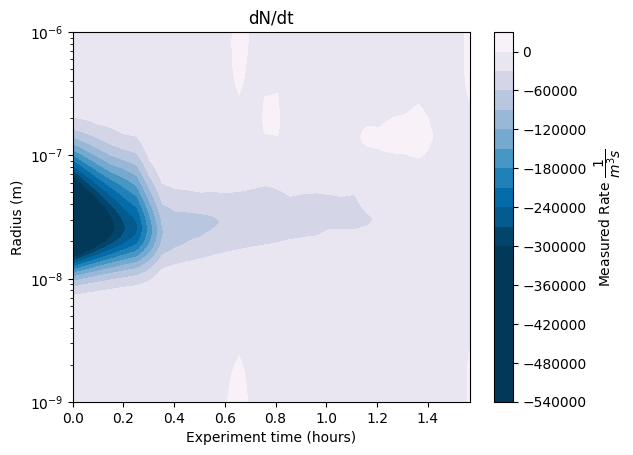

In [12]:
pmf_derivative_stream = stream_stats.time_derivative_of_stream(
    stream=fitted_pmf_stream,
    liner_slope_window_size=10,
)

# Plot the 2d data
fig, ax = plt.subplots(1, 1)
plt.contourf(
    experiment_time,
    pmf_derivative_stream.header_float,
    pmf_derivative_stream.data.T,
    cmap=plt.cm.PuBu_r,
    levels=20,
    vmin=-3e5
)
plt.yscale("log")
ax.set_xlabel("Experiment time (hours)")
ax.set_ylabel("Radius (m)")
ax.set_title("dN/dt")
plt.colorbar(label=r"Measured Rate $\dfrac{1}{m^3 s}$", ax=ax)
plt.show()

## Fitting the Chamber Rates

Now we will fit the chamber rates. We will be fitting the free parameters of `wall_eddy_diffusivity` and `alpha_collision_efficiency`. First we define the chamber and its environment. Then we call the optimization routine to fit the missing rates.

In [13]:
# %% optimize eddy diffusivity and alpha collision efficiency

# set the chamber properties
chamber_parameters = chamber_rate_fitting.ChamberParameters()
chamber_parameters.temperature = 293.15
chamber_parameters.pressure = 78000
chamber_parameters.particle_density = 1600
chamber_parameters.volume = 0.9
chamber_parameters.input_flow_rate_m3_sec = 1.2 * convert_units(
    "L/min", "m^3/s"
)
chamber_parameters.chamber_dimensions = (0.739, 0.739, 1.663)

fit_guess, fit_bounds = chamber_rate_fitting.create_guess_and_bounds(
    guess_eddy_diffusivity=0.1,
    guess_alpha_collision_efficiency=0.5,
    bounds_eddy_diffusivity=(1e-2, 50),
    bounds_alpha_collision_efficiency=(0.1, 1),
)

# % fit chamber eddy diffusivity and alpha collision efficiency
(
    result_stream,
    coagulation_loss_stream,
    coagulation_gain_stream,
    coagulation_net_stream,
    dilution_loss_stream,
    wall_loss_rate_stream,
    total_rate_stream,
) = chamber_rate_fitting.optimize_and_calculate_rates_looped(
    pmf_stream=fitted_pmf_stream,
    pmf_derivative_stream=pmf_derivative_stream,
    chamber_parameters=chamber_parameters,
    fit_guess=fit_guess,
    fit_bounds=fit_bounds,
)

Chamber rates: 100%|██████████| 32/32 [02:15<00:00,  4.24s/it]


**Visualize the results**

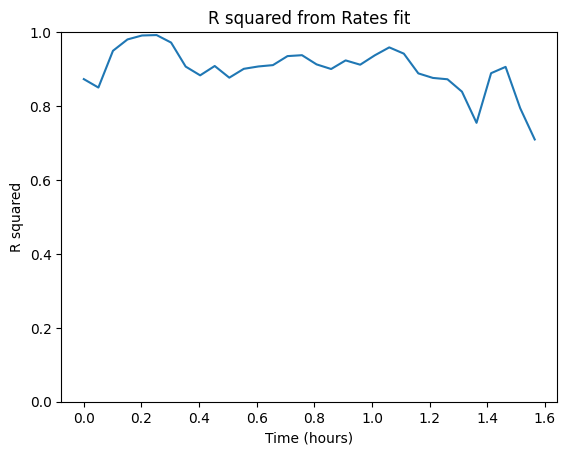

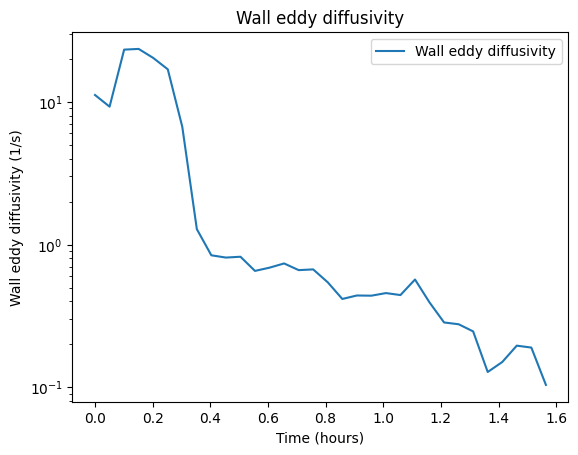

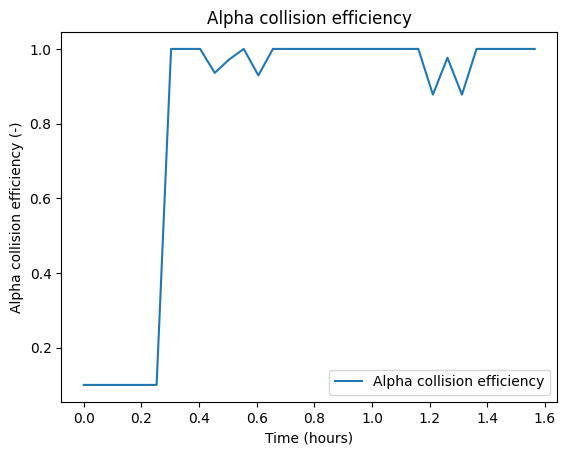

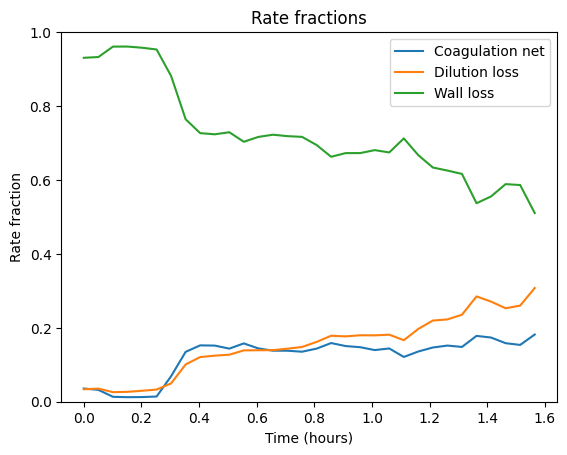

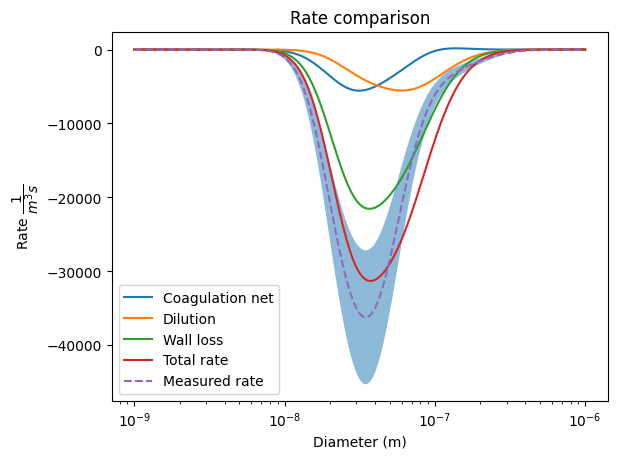

In [17]:
# %% plot the optimized rates

fig, ax = plt.subplots(1, 1)
ax.plot(experiment_time, result_stream["r2_value"])
ax.set_ylim(0, 1)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("R squared")
ax.set_title("R squared from Rates fit")
plt.show()

# plot the optimized values
fig, ax = plt.subplots(1, 1)
ax.plot(
    experiment_time,
    result_stream["wall_eddy_diffusivity_[1/s]"],
    label="Wall eddy diffusivity",
)
ax.set_yscale("log")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wall eddy diffusivity (1/s)")
ax.set_title("Wall eddy diffusivity")
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(
    experiment_time,
    result_stream["alpha_collision_efficiency_[-]"],
    label="Alpha collision efficiency",
)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Alpha collision efficiency (-)")
ax.set_title("Alpha collision efficiency")
plt.legend()
plt.show()

# plot the rate fractions
fig, ax = plt.subplots(1, 1)
ax.plot(
    experiment_time,
    result_stream["coagulation_net_fraction"],
    label="Coagulation net",
)
ax.plot(
    experiment_time,
    result_stream["dilution_loss_fraction"],
    label="Dilution loss",
)
ax.plot(
    experiment_time,
    result_stream["wall_loss_rate_fraction"],
    label="Wall loss",
)
ax.set_ylim(0, 1)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Rate fraction")
ax.set_title("Rate fractions")
plt.legend()
plt.show()

# plot the optimized rates
time_index = 20
radius_m_values = fitted_pmf_stream.header_float
fig, ax = plt.subplots(1, 1)
plt.plot(
    radius_m_values,
    coagulation_net_stream.data[time_index, :],
    label="Coagulation net",
)
plt.plot(
    radius_m_values, dilution_loss_stream.data[time_index, :], label="Dilution"
)
plt.plot(
    radius_m_values,
    wall_loss_rate_stream.data[time_index, :],
    label="Wall loss",
)
plt.plot(
    radius_m_values, total_rate_stream.data[time_index, :], label="Total rate"
)
plt.plot(
    radius_m_values,
    pmf_derivative_stream.data[time_index, :],
    label="Measured rate",
    linestyle="--",
)
plt.fill_between(
    radius_m_values,
    pmf_derivative_stream.data[time_index, :] * 0.75,
    pmf_derivative_stream.data[time_index, :] * 1.25,
    alpha=0.5,
)
plt.xscale("log")
plt.xlabel("Diameter (m)")
plt.ylabel(r"Rate $\dfrac{1}{m^3 s}$")
plt.title("Rate comparison")
plt.legend()
plt.show()

## Conclusion

In this notebook we have fitted the chamber rates using the observations and process simulations. We have used a 2-mode lognormal distribution to fit the size distributions and calculated the time derivative of the size distribution to get the rates. We have then fitted the chamber rates using the optimization routine.